In [596]:
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os

from collections import OrderedDict

import json
import pprint

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, SpatialDropout1D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Acc')
    plt.plot(x, val_acc, 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

In [3]:
subreddit_info = pd.read_csv('subreddit_info.csv')

In [4]:
subreddit_info = subreddit_info[subreddit_info['in_data'] == True]
subreddit_info = subreddit_info.drop(columns=['category_3', 'in_data',
                                              'reason_for_exclusion'], axis=1)
subreddit_info = subreddit_info.reset_index(drop=True)
print(subreddit_info.isnull().sum(), end='\n\n')
print(subreddit_info.shape)
subreddit_info.head()

subreddit     0
category_1    0
category_2    0
dtype: int64

(1013, 3)


,subreddit,category_1,category_2
0,whatsthatbook,advice/question,book
1,theydidthemath,advice/question,calculations
2,datarecovery,advice/question,data recovery
3,declutter,advice/question,declutter
4,productivity,advice/question,discipline


In [5]:
data = pd.read_csv('rspct.tsv', sep='\t')

In [6]:
print(data.isnull().sum(), end='\n\n')
print(data.shape)
data.head()

id           0
subreddit    0
title        0
selftext     0
dtype: int64

(1013000, 4)


,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


In [620]:
data.to_csv('data.csv', index=False)

In [621]:
subreddit_info.to_csv('subreddit_info_cleaned.csv', index=False)

In [485]:
X = data['selftext']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(709100,)
(709100,)
(303900,)
(303900,)


In [486]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
print('Classes:', len(encoder.classes_))
label_map = encoder.inverse_transform(y_train)
print("Reverse Class Mapping Ex. (Subreddit='everquest'):", label_map[4])

Classes: 1013
Reverse Class Mapping Ex. (Subreddit='everquest'): everquest


In [9]:
tokenizer = Tokenizer(num_words=50000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
maxlen = 250

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [11]:
vocab_size = tokenizer.num_words + 1  # add 1 because of reserved 0 index
print(vocab_size)
embedding_dim = 128

50001


In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(709100, 250)
(709100,)
(303900, 250)
(303900,)


In [13]:
logdir = os.path.join('logs', 'early-stopping')
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
stop = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.01, patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1013, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          6400128   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1013)              130677    
Total params: 6,530,805
Trainable params: 6,530,805
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_callback, stop],
                    batch_size=128)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
   1/5540 [..............................] - ETA: 0s - loss: 6.9235 - sparse_categorical_accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5540/5540 [==============================] - 264s 48ms/step - loss: 4.7790 - sparse_categorical_accuracy: 0.2762 - val_loss: 2.7020 - val_sparse_categorical_accuracy: 0.5464
Epoch 2/10
5540/5540 [==============================] - 267s 48ms/step - loss: 2.6098 - sparse_categorical_accuracy: 0.5304 - val_loss: 2.0118 - val_sparse_categorical_accuracy: 0.6292
Epoch 3/10
5540/5540 [==============================] - 270s 49ms/step - loss: 2.1409 - sparse_categorical_accuracy: 0.5958 - val_loss: 1.7793 - val_sparse_categorical_accuracy: 0.6604
Epoch 4/10
5540/5540 [==============================] - 26

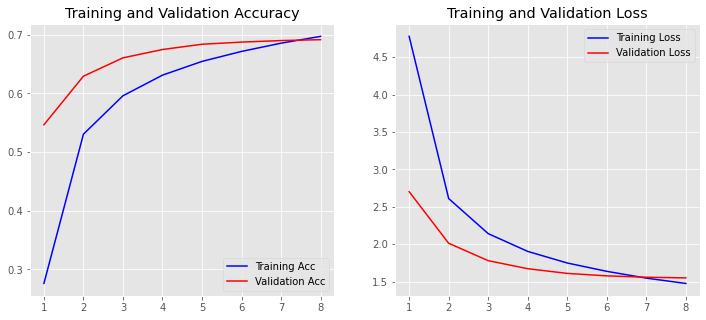

In [15]:
plot_history(history)

In [16]:
# Save model
model.save('keras_pred_subreddit_model_v5.h5')

In [17]:
# Save tokenizer
with open('keras_tokenizer_v5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [613]:
# Save label encoder
with open('sklearn_label_encoder_v5.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **New Data Testing**

In [19]:
# Load saved model
restored_model = tf.keras.models.load_model('keras_pred_subreddit_model_v5.h5')
restored_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          6400128   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1013)              130677    
Total params: 6,530,805
Trainable params: 6,530,805
Non-trainable params: 0
_________________________________________________________________


In [20]:
loss, acc = restored_model.evaluate(X_test,  y_test, verbose=2)
print('Model Accuracy: {:5.2f}%'.format(100*acc))

9497/9497 - 33s - loss: 1.5488 - sparse_categorical_accuracy: 0.6914
Model Accuracy: 69.14%


In [21]:
with open('keras_tokenizer_v5.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [614]:
with open('sklearn_label_encoder_v5.pickle', 'rb') as handle:
    encoder = pickle.load(handle)

In [615]:
test_post_1 = '''My cat likes to zone out when I am holding her head in my palm. 
She fell asleep on my chest while I was writing my term paper and I had to take 
a break to support her coconut head properly as she was about to slide down on 
my lap. The break was extended to 20 more minutes lol'''

In [616]:
test_post_2 = '''Was in Vegas this weekend and hit up Speed Vegas. My plan 
originally was to drive the C8 but this time I could afford the Ferrari so I 
went with that and I don't regret my decision at all. Driving a Ferrari was a 
childhood dream come true and its something I'll never forget as long as I live.
The car was super easy to drive and get used to. After the first lap I felt right 
at home with how it drove. Hitting those turns at 55-60mph without having to 
brake or put the gas was amazing. This car handled those turns like a champ and 
I was shocked at how good it was at taking those turns. On the straight-away I 
hit 142mph and it got up to that speed super quick. The sound of the engine right 
behind your head screaming as your floor it is something that you gotta hear.'''

In [617]:
def predict_on_new(input, tokenizer=tokenizer, restored_model=restored_model, 
                   maxlen=maxlen, encoder=encoder):
  seq = tokenizer.texts_to_sequences([input])
  pad_seq = sequence.pad_sequences(seq, maxlen=maxlen)
  pred = restored_model.predict(pad_seq)
  class_names = list(encoder.inverse_transform(pred[0].argsort()[-5:][::-1]))

  t1_category = []
  t2_category = []

  pred_key = ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']

  for c in class_names:
    for i, sub_red in enumerate(subreddit_info['subreddit']):
      if sub_red == c:
        t1_cat = subreddit_info['category_1'].iloc[i]
        t1_category.append(t1_cat)
        t2_cat = subreddit_info['category_2'].iloc[i]
        t2_category.append(t2_cat)

  pred_dict = OrderedDict(zip(pred_key, zip(class_names, zip(t1_category, t2_category))))
  return json.dumps(pred_dict)

In [618]:
test_1 = predict_on_new(test_post_1)
test_1

'{"pred_1": ["cats", ["animals", "cats"]], "pred_2": ["AskVet", ["profession", "vetenarian"]], "pred_3": ["widowers", ["sex/relationships", "widowers"]], "pred_4": ["Psychic", ["religion/supernatural", "ESP"]], "pred_5": ["Ghosts", ["religion/supernatural", "ghosts"]]}'

In [619]:
test_2 = predict_on_new(test_post_2)
test_2

'{"pred_1": ["formula1", ["sports", "formula 1"]], "pred_2": ["mazda3", ["autos", "mazda"]], "pred_3": ["driving", ["hobby", "driving"]], "pred_4": ["Mustang", ["autos", "ford"]], "pred_5": ["needforspeed", ["video_game", "need for speed"]]}'